<a href="https://colab.research.google.com/github/mohammad-hosein/Semi-Blind-MLP/blob/main/Semi_blind_MP_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math
import pandas as pd
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Input,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import svm
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier

# Generating datasets and preprocessing

In [2]:
'''Fading channel for specific number of antennas at transmitter and receiver side'''
j = complex(0, 1) #Imaginary part
def fading_channel (Nt, Nr):
  h_real = np.random.normal(0, 0.5, size = (Nr, Nt))
  h_img = np.random.normal(0, 0.5, size = (Nr, Nt))
  H_Rayleigh = np.array(h_real + h_img*j, dtype = complex)
  
  return H_Rayleigh

In [3]:
'''SSK Constellation set'''
Constellation_set= np.zeros(shape= (4, 4))
Constellation_set[0] = np.array([1, 0, 0, 0])
Constellation_set[1] = np.array([0, 1, 0, 0])
Constellation_set[2] = np.array([0, 0, 1, 0])
Constellation_set[3] = np.array([0, 0, 0, 1])

In [4]:
H_Rayleigh = fading_channel (4,2)

In [5]:
'''Complex noise'''
def noise_complex (N0, Nr):
  n_real = np.random.normal(0, N0, size = Nr)
  n_img=np.random.normal(0, N0, size = Nr)
  noise_complex=np.array(n_real + n_img*j, dtype = complex)
  
  return noise_complex

In [6]:
'''Creating pilot signals'''
def training_pilots_at_receiver (Label):
  i = 0
  
  y_receiver = np.zeros(shape = (4, 2), dtype = "complex_")
  for i in range(Label):
    y_receiver[i] = np.dot(H_Rayleigh, Constellation_set[i], out = None) + noise_complex (0.125, 2)
    i += 1

  y_receiver_real = y_receiver.real
  y_receiver_imag = y_receiver.imag
  y_receiver = np.concatenate((y_receiver_real, y_receiver_imag), axis = 1)
  y_receiver_complex = pd.DataFrame(y_receiver, columns=['Ant1_real', 'Ant2_real', 'Ant1_imag', 'Ant2_imag'])
  y_receiver_complex['Label'] = np.arange(0, 4) 

  return y_receiver_complex

In [7]:
training_pilots_at_receiver = training_pilots_at_receiver (4)

In [8]:
'''Creating test signals'''
def test_ (packet_length):
  #Define an empty dataframe
  y_receive_test = pd.DataFrame()

  for i in range(packet_length):
    #Generating received signals
    y_one_receive_signal = np.zeros(shape = (1, 2), dtype = "complex_")
    
    #Choosing a random constellation point
    rand = random.randrange(0, 4, 1)
    
    #Y = HX+N 
    y_one_receive_signal = np.dot(H_Rayleigh, Constellation_set[rand], out = None) + noise_complex (0.125, 2)
    
    #Transforming complex signal to a two dimension integer
    y_one_receive_signal_real = y_one_receive_signal.real
    y_one_receive_signal_imag = y_one_receive_signal.imag
    y_receive = np.concatenate((y_one_receive_signal_real,y_one_receive_signal_imag), axis = None)
    
    #Filling dataframe rows
    y_receive_without_label = pd.DataFrame(y_receive.reshape((1, 4)), columns = ['Ant1_real', 'Ant2_real', 'Ant1_imag', 'Ant2_imag'])
    
    #Assigning related label to received pilots
    if rand == 0 :
      y_receive_without_label['Label']= 0
    elif rand == 1 :
      y_receive_without_label['Label']= 1
    elif rand == 2 :
      y_receive_without_label['Label']= 2
    elif rand == 3 :
      y_receive_without_label['Label']= 3
    
    #Join all test signals to data set
    y_receive_test = pd.concat([y_receive_test, y_receive_without_label])

  return y_receive_test

In [9]:
def test_label (KNN_or_NN): #Depend on model
  test = test_ (200)

  #Test data for KNN
  if KNN_or_NN == 1 :
    test_features = test[['Ant1_real', 'Ant2_real', 'Ant1_imag', 'Ant2_imag']]
    test_label = test['Label']
    return test_features, test_label

  #Test data for NN
  elif KNN_or_NN == 0:
    test_features = test[['Ant1_real', 'Ant2_real', 'Ant1_imag', 'Ant2_imag']]
    test_label_NN = test['Label']
    #test_label_categorical = to_categorical(test_label, num_classes = 4)
    return test_features, test_label_NN

In [10]:
test_label (1)

(    Ant1_real  Ant2_real  Ant1_imag  Ant2_imag
 0    0.382446  -0.399711  -0.090425  -0.345863
 0   -0.069214  -1.080143   0.521546   0.439336
 0   -0.046950   0.554203   0.403747  -0.082161
 0   -0.210564  -1.021116   0.573574   0.374670
 0   -0.653730  -0.062315   0.152287  -0.173028
 ..        ...        ...        ...        ...
 0    0.014985  -0.991083   0.427071   0.158015
 0   -0.023746  -1.191029   0.160355   0.172305
 0   -0.137956   0.604671   0.493338   0.074191
 0   -0.019732   0.600831   0.370174   0.092782
 0   -0.161646   0.609596   0.291453   0.244824
 
 [200 rows x 4 columns], 0    2
 0    0
 0    3
 0    0
 0    1
     ..
 0    0
 0    0
 0    3
 0    3
 0    3
 Name: Label, Length: 200, dtype: int64)

In [11]:
x_test_svm, y_test_svm = test_label (1)
x_test_nn, y_test_nn = test_label (0)


# Generating virtual pilots (data augmentation)

In [12]:
'''Noise for data augmentation'''
def noise_real (N0,Nr):
  noise_real=np.random.normal(0, N0, size=Nr)
  
  return noise_real

In [13]:
def data_augmentation (sample_size, noise_variance):
  #Generating virtual pilots based on actual pilots
  augmented_data = pd.DataFrame()

  for i in range(sample_size):
    frame_augmented = training_pilots_at_receiver[['Ant1_real', 'Ant2_real', 'Ant1_imag', 'Ant2_imag']] + noise_real(noise_variance, 4)
    frame_augmented['Label'] = np.arange(0, 4)
    augmented_data = augmented_data.append(frame_augmented)
    i += 1

  return augmented_data

In [14]:
data_augmentation = data_augmentation(300, 0.012)

In [15]:
print(data_augmentation.describe())
print(training_pilots_at_receiver.describe())

         Ant1_real    Ant2_real    Ant1_imag    Ant2_imag      Label
count  1200.000000  1200.000000  1200.000000  1200.000000  1200.0000
mean     -0.064062    -0.078209     0.194266    -0.131224     1.5000
std       0.293936     0.585681     0.189548     0.234348     1.1185
min      -0.525463    -0.904216    -0.139361    -0.405025     0.0000
25%      -0.239836    -0.512121     0.103112    -0.318991     0.7500
50%      -0.051916    -0.049826     0.264371    -0.206192     1.5000
75%       0.121565     0.381517     0.349912    -0.022047     2.2500
max       0.363877     0.680756     0.413718     0.278023     3.0000
       Ant1_real  Ant2_real  Ant1_imag  Ant2_imag     Label
count   4.000000   4.000000   4.000000   4.000000  4.000000
mean   -0.063378  -0.077035   0.194645  -0.131855  1.500000
std     0.338984   0.675884   0.218377   0.270138  1.290994
min    -0.484672  -0.869613  -0.111196  -0.367146  0.000000
25%    -0.217953  -0.492947   0.114129  -0.298556  0.750000
50%    -0.048940  -

# Split dataset to train and test

In [16]:
'''Spliting features and labels'''
#xy=pd.concat([data_augmentation, training_pilots_at_receiver])       #Enable when you want vp for SVM & KNN
xy = training_pilots_at_receiver                      #Enable when you dont want vp for SVM & KNN
xy_NN = pd.concat([data_augmentation, training_pilots_at_receiver])     #Enable when you want vp for NN
#xy_NN = training_pilots_at_receiver                   #Enable when you dont want vp for NN

In [17]:
xy

,Ant1_real,Ant2_real,Ant1_imag,Ant2_imag,Label
0,-0.129046,-0.869613,0.327244,0.246127,0
1,-0.484672,0.275227,0.189238,-0.275693,1
2,0.329039,-0.367392,-0.111196,-0.367146,2
3,0.031166,0.653638,0.373293,-0.130708,3


#Preprocessing for KNN & SVM

In [18]:
scaler = StandardScaler()

In [19]:
scaler.fit(xy.drop('Label',axis=1))

StandardScaler()

In [20]:
scaled_features = scaler.transform(xy.drop('Label',axis=1))

In [21]:
xy = pd.DataFrame(scaled_features,columns=xy.columns[:-1])
xy['Label']=np.arange(0,4)
xy

,Ant1_real,Ant2_real,Ant1_imag,Ant2_imag,Label
0,-0.223687,-1.354063,0.701140,1.615680,0
1,-1.435077,0.601814,-0.028590,-0.614832,1
2,1.336713,-0.496055,-1.617178,-1.005751,2
3,0.322051,1.248304,0.944628,0.004902,3


#Preprocessing for MLP

In [22]:
xy_NN

,Ant1_real,Ant2_real,Ant1_imag,Ant2_imag,Label
0,-0.149839,-0.871490,0.313194,0.262046,0
1,-0.505465,0.273349,0.175187,-0.259774,1
2,0.308246,-0.369270,-0.125247,-0.351227,2
3,0.010373,0.651761,0.359242,-0.114789,3
0,-0.151791,-0.877932,0.321461,0.263680,0
...,...,...,...,...,...
3,0.019567,0.660365,0.376866,-0.136747,3
0,-0.129046,-0.869613,0.327244,0.246127,0
1,-0.484672,0.275227,0.189238,-0.275693,1
2,0.329039,-0.367392,-0.111196,-0.367146,2


In [23]:
'''preprocessing for NN'''
x_NN=xy_NN[['Ant1_real','Ant2_real','Ant1_imag','Ant2_imag']]
y_NN=xy_NN['Label']
'''Labels one hot encoding'''
#y_NN=to_categorical(y_NN, num_classes=4)
'''Spliting data to train and validation'''
X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(x_NN, y_NN, test_size=0.3, random_state=101)

In [24]:
'''Spliting features and labels for SVM & KNN'''
x=xy[['Ant1_real','Ant2_real','Ant1_imag','Ant2_imag']]
y=xy['Label']

In [25]:
xy

,Ant1_real,Ant2_real,Ant1_imag,Ant2_imag,Label
0,-0.223687,-1.354063,0.701140,1.615680,0
1,-1.435077,0.601814,-0.028590,-0.614832,1
2,1.336713,-0.496055,-1.617178,-1.005751,2
3,0.322051,1.248304,0.944628,0.004902,3


In [26]:
'''Spliting data to train and validation'''
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.000001, random_state=101)
X_train=x
y_train=y

In [27]:
X_train.shape

(4, 4)

In [28]:
y_train.shape

(4,)

In [29]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.97 and logs.get('loss')<0.07):
      print("\nReached 97% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

# Building neural network and training

In [30]:
model = Sequential()
model.add(Input(shape=(4)))
model.add(Dense(64, activation=keras.layers.LeakyReLU(alpha=0.01)))
model.add(Dense(4, activation='softmax'))

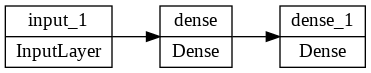

In [31]:
plot_model(model, to_file='model.png', rankdir='LR')


In [32]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_NN, y_train_NN, batch_size=32, epochs=50, validation_data=(X_test_NN,y_test_NN),callbacks=[callbacks])

Epoch 1/50
27/27 [==============================] - 2s 17ms/step - loss: 1.3529 - accuracy: 0.4691 - val_loss: 1.2364 - val_accuracy: 0.9917
Epoch 2/50
27/27 [==============================] - 0s 6ms/step - loss: 1.1481 - accuracy: 1.0000 - val_loss: 1.0439 - val_accuracy: 1.0000
Epoch 3/50
27/27 [==============================] - 0s 6ms/step - loss: 0.9605 - accuracy: 1.0000 - val_loss: 0.8530 - val_accuracy: 1.0000
Epoch 4/50
27/27 [==============================] - 0s 6ms/step - loss: 0.7732 - accuracy: 1.0000 - val_loss: 0.6690 - val_accuracy: 1.0000
Epoch 5/50
27/27 [==============================] - 0s 5ms/step - loss: 0.5959 - accuracy: 1.0000 - val_loss: 0.5051 - val_accuracy: 1.0000
Epoch 6/50
27/27 [==============================] - 0s 7ms/step - loss: 0.4427 - accuracy: 1.0000 - val_loss: 0.3691 - val_accuracy: 1.0000
Epoch 7/50
27/27 [==============================] - 0s 4ms/step - loss: 0.3204 - accuracy: 1.0000 - val_loss: 0.2677 - val_accuracy: 1.0000
Epoch 8/50
27/27 [=

In [33]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 580
Trainable params: 580
Non-trainable params: 0
_________________________________________________________________


In [34]:
#plot_decision_regions(X_test_NN, y_test_NN, clf=model, legend=2)
#plt.show()

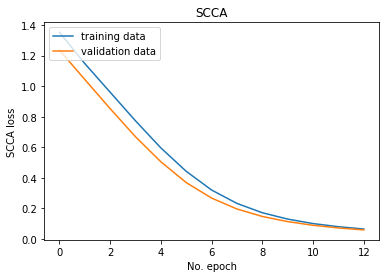

In [35]:
# Plot history
plt.plot(history.history['loss'], label='training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('SCCA')
plt.ylabel('SCCA loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

# Training KNN and SVM model

In [36]:
rbf = svm.SVC(kernel = 'rbf', gamma = 0.5, C = 0.1).fit(X_train, y_train)
poly = svm.SVC(kernel = 'poly', degree = 3, C = 1).fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train,y_train)

# Testing models on test dataset 

In [37]:
poly_pred = poly.predict(x_test_svm)
rbf_pred = rbf.predict(x_test_svm)
knn_pred = knn.predict(x_test_svm)

In [38]:
knn_accuracy = accuracy_score(y_test_svm, knn_pred)
knn_f1 = f1_score(y_test_svm, knn_pred, average ='weighted')
print('Accuracy (KNN): ', "%.2f" % (knn_accuracy*100))
print('F1 (KNN): ', "%.2f" % (knn_f1*100))

Accuracy (KNN):  87.00
F1 (KNN):  86.17


In [39]:
poly_accuracy = accuracy_score(y_test_svm, poly_pred)
poly_f1 = f1_score(y_test_svm, poly_pred, average = 'weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  25.50
F1 (Polynomial Kernel):  10.36


In [40]:
rbf_accuracy = accuracy_score(y_test_svm, rbf_pred)
rbf_f1 = f1_score(y_test_svm, rbf_pred, average = 'weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  87.00
F1 (RBF Kernel):  86.17


In [41]:
'''Test the model'''
NN_Accuracy = model.evaluate(x_test_nn, y_test_nn)

7/7 [==============================] - 0s 4ms/step - loss: 0.1156 - accuracy: 0.9950


#Choosing K value

In [42]:
'''error_rate = []

for i in range(1,4):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(m1)
    error_rate.append(np.mean(pred_i != n1))'''

'error_rate = []\n\nfor i in range(1,4):\n    knn = KNeighborsClassifier(n_neighbors=i)\n    knn.fit(X_train,y_train)\n    pred_i = knn.predict(m1)\n    error_rate.append(np.mean(pred_i != n1))'

In [43]:
'''plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue',ls='--',marker='o',markerfacecolor='red',markersize=10)
plt.title('Error Rate vs. K Values')
plt.xlabel('K')
plt.ylabel('Error Rate')'''

"plt.figure(figsize=(10,6))\nplt.plot(range(1,40),error_rate,color='blue',ls='--',marker='o',markerfacecolor='red',markersize=10)\nplt.title('Error Rate vs. K Values')\nplt.xlabel('K')\nplt.ylabel('Error Rate')"